# Topic modeling with BERTopic

**_Source:_** This notebook is based on the ["Topic Modeling with BERTopic" notebook](https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-) by [Maarten Grootendorst](https://twitter.com/grtndrst). 

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/main/notebooks/topic_modeling/topicmodel_bertopic.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Outline**

1. Setup: load libraries and set globals
2. Data: load the data
3. Topic modeling: prepare the compoments for your BERTopic model, fit it to the data, and post-process topics' bag-of-words representations
4. Evaluation: evaluate topic quality
5. Interpretation and topic labeling
6. Advanced stuff

# Setup

In [1]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
        # shallow clone of current state of main branch 
    !git clone --branch main --single-branch --depth 1 --filter=blob:none https://github.com/haukelicht/advanced_text_analysis.git
    # make repo root findable for python
    import sys, os
    sys.path.append(f"{os.getcwd()}/advanced_text_analysis/")

    # install required packages
    !pip install -q sentence-transformers~=5.1.0 bertopic==0.17.3

    import nltk
    nltk.download('punkt')

In [2]:
import os
from pathlib import Path

# for data wrangling
import pandas as pd
import numpy as np


# test processing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# for topic modeling
import torch
if torch.backends.mps.is_available():
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
## "document" embedding
from sentence_transformers import SentenceTransformer
## dimensionality reduction
from umap import UMAP 
## clustering
from hdbscan import HDBSCAN
## for bag-of-words topic representations
from bertopic.vectorizers import ClassTfidfTransformer 

## topic modeling
from bertopic import BERTopic 

# for visaualization
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_modeling import compute_coherece, plot_topic_coherence_scores, compute_silhouette_scores

In [3]:
data_path = "data/unlabeled/louwerse_oppoistion_2021"
data_path = ("/content/advanced_text_analysis/" if COLAB else "../../") + data_path
data_path = Path(data_path)

In [4]:
SEED = 42

## Load the example data

Here we use a corpus of sentences from speeches delivered by opposition speakers in the UK *House of Commons* in debates about COVID-19-related topics.
The data has been collected by Tom Louwerse et al. ([2021](https://doi.org/10.1080/01402382.2021.1886519)) and we have obtained the raw (annotated) speech sentences from the authors.

In [5]:
fp = data_path / "louwerse_oppoistion_2021-uk_covid_speeches.csv"
if not fp.exists():
    url = "https://cta-text-datasets.s3.eu-central-1.amazonaws.com/unlabeled/louwerse_oppoistion_2021/louwerse_oppoistion_2021-uk_covid_speeches.csv"
    df = pd.read_csv(url)
    fp.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(fp, index=False)

In [93]:
df = pd.read_csv(fp)

In [94]:
# convert to sentence-level data
df['text'] = df.text.str.split('\n')
df = df.explode('text')

df.reset_index(drop=True, inplace=True)

## Topic modeling

With a data frame of sentences, we could just fit a BERTopic model directly:

```python
topics, _ = BERTopic(language='english').fit_transform(df.text)
```

But for many of BERTopic's components, there are good reasons to alter and costumized them.
So below, we'll create these components one by one, and then combine them in our specialized BERTopic.

### Prepare the topic model components

#### 1. Sentence embeddings

The first compoment of BERTopic is an embedding model that allows generating an embedding vector for each input document.
In our case, our "documents" are (quasi-)sentences.
So we'll rely on a pre-trained sentence embedding model.
This is also BERTopic's default behavior.

However, by default, each time we fit the topic model to our texts, BERTopic will compute these embeddings.
To avoid this, we will just obtain the embeddings of the texts in our corpus once and reuse them wenever we fit a BERTopic model.
We can do this because the pre-trained sentence embedding model is deterministic.

In this way, we can  reuse our sentences' embeddings later if we change the model's parameters (e.g., during hyperparameter optimization).

source: https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=sVfnYtUaxyLT

In [8]:
# instantiate a sentence embedding model (source: https://www.sbert.net/docs/pretrained_models.html)
embedding_model_name = 'all-mpnet-base-v2'
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
embedding_model = SentenceTransformer(embedding_model_name, device=device) #, trust_remote_code=True)

**_Notes:_** 

- The author of BERTtopic points to the leaderboard for a sentence embedding benchmark on his website: https://huggingface.co/spaces/mteb/leaderboard ([*source*](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)). There you might find a model that achieves better performance, like 'dunzhang/stella_en_400M_v5' or 'Alibaba-NLP/gte-large-en-v1.5'

- you can also use a LLM embedding models. But for commercial providers, like Cohere or OpenAI, you'll need API tokens; see [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#cohere) and [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#openai).

#### Important 

It's important to remember that *every* transformer has a maximum number of tokens it can ingest per input document.
As the developer of BERTopic notes:

> ... as the name implies, the [sentence] embedding model works best for either sentences or paragraphs. This means that whenever you have a set of documents, where each documents contains several paragraphs, the document is truncated and the topic model is only trained on a small part of the data. ([*source*](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#document-length))

So you should **always check** if the documents you want to embed are too long for the model you want to use.

In [9]:
# get the embedding model's max sequence length (measured in tokens)
embedding_model.max_seq_length

384

In [10]:
# tokenize your texts with the pre-trained model and get the length of each tokenized text
df['n_toks'] = embedding_model.tokenizer(df.text.tolist(), return_length=True, truncation=False).length

In [11]:
# compute share of sentences that will be truncated
(df['n_toks'] > embedding_model.max_seq_length).mean()

0.0

Fortunately, only a tiny hand full of sentences exceed the `max_seq_length` limit.
(These sentences will be truncated, meaning some words at their end will be omitted.)
So we can proceed.

**_Note:_** 
If our documents are too long, read [this thread](https://www.reddit.com/r/LanguageTechnology/comments/xh71yt/comment/j4fbqti/).
They suggest to use a Transformer model with a higher max. sequence length (e.g., a "Longformer").
This you could use to create document embeddings with the huggingface `pipeline` API (see [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#hugging-face-transformers)). 
Alternatively, you can consider an [alternative document representation](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html) approach.

In [12]:
len(df)

4864

In [13]:
# WARNING: this will take some time (~1.5 minutes) if you use a CPU
embeddings = embedding_model.encode(df.text.tolist(), batch_size=16, show_progress_bar=True)

Batches:   0%|          | 0/304 [00:00<?, ?it/s]

#### 2. Dimensionality reduction

Given embedding representations of the documents in your corpus, the next step in BERTopic is to reduce their dimensionality.
This is done to distill the relevant signlas in your corpus (i.e., reduce noise) and speed up the clustering process.

By default, BERTopic uses [UMAP](https://umap-learn.readthedocs.io) for dimensionality reduction (McInnes  et al., [2018](https://arxiv.org/abs/1802.03426)).
We will stick to this choice and use the default parameters (see [here](https://github.com/MaartenGr/BERTopic/blob/7d07e1e94e69be278f79a48d73602cdc4df0885f/bertopic/_bertopic.py#L239)) with one exception: I have increased the number of components from 5 (default) to 25.
This means that our documents will be represented in a 25-dimensional space.
Retaining more UMAP-components will provide more information to the clustering algorithm.
But you could fine-tune this parameter (see more below).

But even if you do not want to adapt the pre-set values, it's advisable to instantiate the dimensionality reduction component explicitly because this allos you to set a random seed (using the `random_state` parameter, see [here](https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=28_EVoOfyZLb)):

**_Note:_** Common alternatives to UMAP for dimensionality reduction are TSNE or TruncatedSVD (see [here](https://maartengr.github.io/BERTopic/getting_started/dimensionality_reduction/dimensionality_reduction.html)).




In [14]:
umap_model = UMAP(
    n_neighbors=30, 
    n_components=50, # <== I increased this from 5 to 50
    min_dist=0.0, 
    metric='cosine', 
    random_state=SEED
)

**_Note:_** For document clustering, BERTopic uses HDBSCAN.
There is no argument for setting a seed.
So the only thing we can do to ensure reproducibility is calling `np.random.seed(SEED)` before running `BERTopic.fit_transform` (see [here](https://github.com/scikit-learn-contrib/hdbscan/issues/326#issuecomment-669323791) and [here](https://www.reddit.com/r/datascience/comments/hkm2hc/comment/fx0dam7/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button)).

#### 3. Clustering method 

BERTopic finds topics by clustering the documents representation in the dimensionality-reduced embedding space.
By default, it uses the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) clustering algorithm.

Explicitly instantiating the clustering model is important because its the only way how you can affect how many topics BERTopic discovers for your data (see [here](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#influence-the-number-of-topics)).

Specifically, HDBSCAN has a parameter `min_topic_size` that *in*directly controls the number of topics that will be created.
A higher `min_topic_size` will generate fewer topics and a lower `min_topic_size` will generate more topics.

**_Note:_** 
There is a parameter for `BERTopic` to control the number of topics: `nr_topics`. But this parameter merges topics **after** they have been created.
So if you want to influence the number of topics at training time, this can be done through the cluster model.
by default, `BERTopic` uses HDBSCAN for clustering. 


In [15]:
cluster_model = HDBSCAN(
    min_cluster_size=8,
    metric='euclidean', # <== default
    cluster_selection_method='eom', # <== default
    prediction_data=True # <== required (default)
)

**_Note:_** It's also important to know that lower `min_cluster_size` will mean that the clustering algorithm runs for a longer time to converge.

##### *Caveat of HDBSCAN*

There is one caveat of using HDBSCAN when working with **relatively short documents**, like sentences:
It typically categorizes realtively many documents into a single outlier cluster (cf. Groot et al., [2022](https://arxiv.org/abs/2212.08459)).

I observed this, too, with our data:
When setting `min_cluster_size` to a value between 20 and 48, HDBSCAN found many topics (100+ for lower `min_cluster_size` values, around 50-30 for higher values) but assigned 50%+ documents to the outlier cluster.
When seetting `min_cluster_size` to a value between 49 and 55, HDBSCAN found typically only four topics and while only ~5% of the documents were assigned to the outlier cluster, of course the others were distributed across only very few, kind of "catch all" topics.

According to de Groot et al. ([2022](https://arxiv.org/abs/2212.08459)), one solution to this problem is to use **_k_-means** instead of HDBSCAN for clustering.
Using *k*-means has the additional benefits that 
(a) we can set the number of topics directly,
and
(b) we can set a random seed for reproducibility.
A doneside is that it has no machanism to identify outlier documents.
So we want to remember to check topics' silhouette scores during evaluation to see if there are any documents that are not well assigned to any topic!

Below we instantiate a *k*-means clustering model and set the number of topics to 25.

In [16]:
# # note: if you use short texts, use k-means:
# from sklearn.cluster import KMeans
# cluster_model = KMeans(n_clusters=15, random_state=SEED)
# # NOTE: n_clusters determines the number of topics (decided based on APPENDIX section below)

#### 4. Topic representation

To describe the topics BERTopic induces on your data through embedding, dimensionality reduction, and clustering, it identifies the words in a topic's documents that are most representative of that topic.
This is done by computing the *cluster*-tf-idf (c-tf-idf) score, which is just the tf-idf score computed from "topic documents", which just combine all documents assigned to a given topic into one long text (see [here](https://maartengr.github.io/BERTopic/api/ctfidf.html)).

Because the c-tf-idf alfgorithm is based on relative token counts, all the usual caveats of bag-of-words representations apply.
So it's advisable to alter this component to get rid of frequent words like "stopwords" in your topic representations (see [here](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words)).

Let's first get a list of stopwords

In [17]:
stop_words = stopwords.words('english')

**_Note:_** It'd be ideal to apply language-specific pre-processing and tokenization.
But this is a little advanced and we thus show you how to do it only at the end of this notebook (in the "Advanced" section).

No we can instantiate a count vectorizer that removes these stopwords and also removes very (in)frequent words.

In [18]:
vectorizer_model = CountVectorizer(max_df=0.80, min_df=0.1, ngram_range=(1, 3), stop_words=stop_words)

In addition, we can explicitly configure the c-tf-idf component to reduce the impact of frequent words (by computing the square root of c-tf-idf scores, see [here](https://github.com/MaartenGr/BERTopic/blob/7d07e1e94e69be278f79a48d73602cdc4df0885f/bertopic/vectorizers/_ctfidf.py#L107C13-L107C13)).

In [19]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

### Finally: create the **Topic Model** instance

Now we are ready to instantiate our BERTopic model

In [95]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

topic_model = BERTopic(

  # components
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=cluster_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=KeyBERTInspired(top_n_words=30),
  
  # parameters
  nr_topics=None, # <== I've removed this to avoid merging topics after estimation

  # Hyperparameters
  calculate_probabilities=True, # WARNING: this can slow down BERTopic significantly at large amounts of data (>100_000 documents)
  top_n_words=5, # <== set lower than default (10)

  verbose=True
)

#### A note on the `calculate_probabilities` argument

If you set this to `calculate_probabilities=True`, BERTopic will compute the probability of each document belonging to each of the inferred topics.
This is nice because it makes BERTopic's output more akin to the output of a probabilistic topic model like LDA.

*Caveats:*

- For large corpora, this can be computationally expensive.
- Whether you can obtain these quantities depends on the clustering algorithm you use. For example, *k*-means does not allow to compute document-topic probabilities!

<!-- (The default, HDBSCAN, does allow this. But it has the downside that it assigns many documents to an outlier cluster in our use case.) -->


# Fitting

To train/fit the model, we call the model's `fit_transform` method and provide out corpus and the pre-computed embeddings.

In [96]:
np.random.seed(SEED) # <== set seed for reproducibility
topics, probs = topic_model.fit_transform(df.text, embeddings=embeddings)

2025-09-23 16:09:11,517 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-23 16:09:27,937 - BERTopic - Dimensionality - Completed ✓
2025-09-23 16:09:27,939 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-23 16:09:29,130 - BERTopic - Cluster - Completed ✓
2025-09-23 16:09:29,134 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-23 16:09:30,826 - BERTopic - Representation - Completed ✓


`topics` will record the inferred topic assignemnts (i.e., the topic label for each document in our corpus). It's a list of integers, where each integer is the index of the topic in the list of topics and the list is as long as our corpus has documents.

`probs` records the inferred topic probabilities for each document if `calculate_probabilities` is `True` (see above).
(If `calculate_probabilities` is `False`, `probs` will be `None`.)
If `calculate_probabilities` is `True`, `probs` will be a 2d numpy array of floats, with as many rows as documents documents in the corpus and as many columns as topics.


After fitting, the resulting `bertopic.BERtopic` instance (here, called "topic_model") has the following attributes:

| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

Let's add the model's topic assignments ("classification") to our setences data frame:


In [97]:
df['topic_'] = topic_model.topics_ 
# note: putting an underscore at the end of a (attribute) name is customary to indicate that it is an infered quantity


#### A note on terminology

BERTopic is an *unsupervised* method.
If, like me, you work a lot with labeled data, you might associate training with supervised learning.
So "training" is a bit of a misnomer.
Maybe it'd be better to say "fitting" the model.
But I just started off with the notebook the BERTopic developer provided and hence kept the terminology.

# Inspecting the output

Let's inspect a number of important attributes of the model:

In [98]:
# how many topics?
n_topics = len(set(topic_model.topics_))
n_topics
# NOTE: for k-means, this should be equal to n_clusters above (but for HDBSCAN it's determined from the data

63

**_Notes:_**

- one of the topics will be labeled "-1" if you use HDBSCAN. This is an outlier topic
- If you only get 1 topic (plus the topic model, reduce `min_cluster_size` in HDBSCAN)

In [99]:
# how many docs assigned to outlier topic?
topic_model.get_topic_freq(-1)/len(df)
# NOTE: this will be non-zero only if you use HDBSCAN

0.39535361842105265

In [100]:
has_outlier_topic = -1 in topic_model.topics_

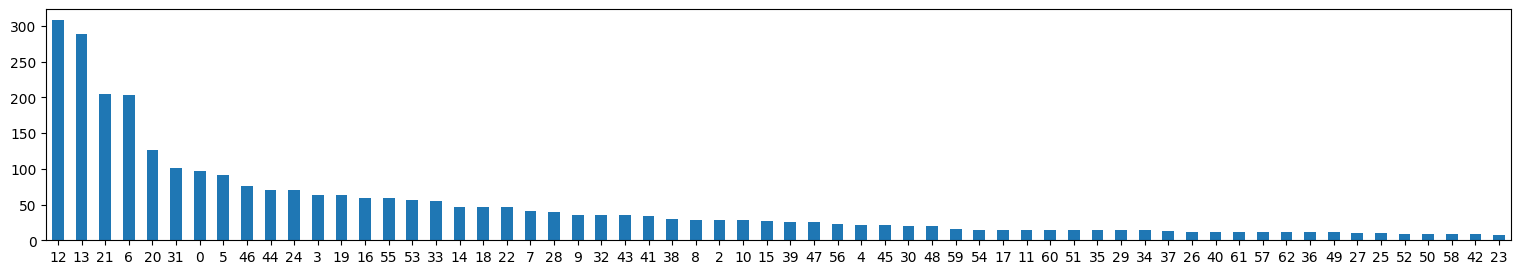

In [101]:
# how many docs per topics, excluding the "outlier" topic? (plot histogram)
topic_model.get_topic_freq().query("Topic != -1")['Count'].plot(kind='bar', figsize=(n_topics*0.3, 3))
plt.xticks(rotation=0)
plt.show()

In [102]:
# how large is the vocabulary?
len(topic_model.vectorizer_model.get_feature_names_out())

907

### Looking at individual topics

We can look at 

1. topic-word "loadings" (the probability that a word occurs in a document assigned to a given topic)
2. representative documents (i.e., documents assigned to a topic that are central to the given topic cluster's cnetroid)

In [103]:
# topic-word "loadings"
topic_model.get_topic(0)

[('nhs', 0.47310522),
 ('healthcare', 0.33749694),
 ('hospitals', 0.30137116),
 ('care staff', 0.2868206),
 ('health social care', 0.27028912),
 ('health social', 0.26455665),
 ('medical', 0.25112376),
 ('worried', 0.24139227),
 ('hospital', 0.24115068),
 ('social care', 0.23725203),
 ('protect', 0.21957761),
 ('care homes', 0.20740867),
 ('local authorities', 0.20083305),
 ('vulnerable people', 0.19503939),
 ('mental health', 0.16614538),
 ('sufficient', 0.15862128),
 ('residents', 0.15780152),
 ('authorities', 0.14881839),
 ('ensure', 0.13698179),
 ('care', 0.13431829),
 ('vulnerable', 0.12875667),
 ('deaths', 0.1247463),
 ('access', 0.12250696),
 ('frontline', 0.11399171),
 ('staff', 0.10748689),
 ('levels', 0.10662924),
 ('provide', 0.10481076),
 ('homes', 0.10309081),
 ('children', 0.10284693),
 ('provisions', 0.101834685)]

In [104]:
# representative documents
topic_model.representative_docs_[0]

['On 11 March I asked the Secretary of State for Health and Social Care whether he would be issuing personal protective equipment to social care workers, he said“we are taking that into account”.',
 'We welcome the distribution of personal protective equipment to NHS staff, but does the Secretary of State agree that GPs and social care staff also need access to that equipment?',
 'What support is in place for the residents of care homes, and when will we get the PPE that we need into the social care sector?']

In [105]:
topic_model.get_topic(1)

[('impact covid 19', 0.4352504),
 ('public health england', 0.39448863),
 ('impact covid', 0.38897318),
 ('health england', 0.36715323),
 ('covid 19', 0.35885072),
 ('coronavirus', 0.332977),
 ('risks', 0.29184768),
 ('healthcare', 0.29084843),
 ('acknowledge', 0.28951415),
 ('parliament', 0.28065667),
 ('covid', 0.2751126),
 ('indeed', 0.2584875),
 ('action', 0.23323108),
 ('agree', 0.23319212),
 ('london', 0.22185329),
 ('increased', 0.2197847),
 ('positive', 0.20600355),
 ('risk', 0.20488387),
 ('evidence', 0.1979014),
 ('impact', 0.19261372),
 ('large', 0.1884868),
 ('result', 0.18739192),
 ('reports', 0.18509173),
 ('towards', 0.18424107),
 ('report', 0.18313572),
 ('areas', 0.1802855),
 ('workforce', 0.1749369),
 ('times', 0.17332426),
 ('england', 0.17209376),
 ('constituency', 0.1717239)]

In [106]:
topic_model.representative_docs_[1]

['With all that in mind, plus the fact that Pakistani deaths are 2.9 times as high as deaths among white British people, it sadly seems as though my diverse constituency is at a greater risk of being disproportionately affected by covid-19.',
 'Last week, we learned of the existence of Public Health England’s second report “Understanding the impact of COVID-19 on BAME groups”, which had not been released.',
 'The verdict, as we heard from the Public Health England report and we know from our own experience, was that the risk from covid-19 is generally higher among BAME communities, even after adjusting for risk factors such as age, gender, comorbidities, increased likelihood to live in urban areas, and so on.']

# Evaluation

There is quite some literature on evaluating topic models (e.g., Wallach et al., [2009](https://www.cs.cmu.edu/~rsalakhu/papers/etm.pdf); Lau et al., [2014](https://aclanthology.org/E14-1056.pdf); Röder et al., [2015](https://doi.org/10.1145/2684822.2685324)) that has proposed topic-model specific evaluation metrics, formostly *coherence*.

But since BERTopic is effectively a *clustering method*, where the topic-like flavor comes only trough the added (post-clustering) identification of characteristic topic words, its helpful to consult the literature on evaluating clusterings, too (see [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)).

Importantly, we have no ground-truth document class assignments against which we could compare the topics BERTopic has found.
So we need to constraint ourselves to unsupervised evaluation methods like silhouette scores.

## Coherence

Coherence indicates how much a set of statements supports each other ()
In the context of topic modeling, coherence is a measure of how semantically similar the words in a topic are.
There are different coherence measures ([source](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#e51b))

- $C_\text{v}$ measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
- $C_\text{p}$ is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
- $C_\text{uci}$ measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
- $C_\text{umass}$ is based on document co-occurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
- $C_\text{npmi}$ is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
- $C_\text{a}$ is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

ChatGPT can help you in understanding in detail how these measures are computed ([example](https://chat.openai.com/share/743c0a0f-fece-40ec-bae6-fd13eff4fb7b))

In [107]:
coherence_scores, _ = compute_coherece(topic_model, df.text, coherence_metric='c_v')

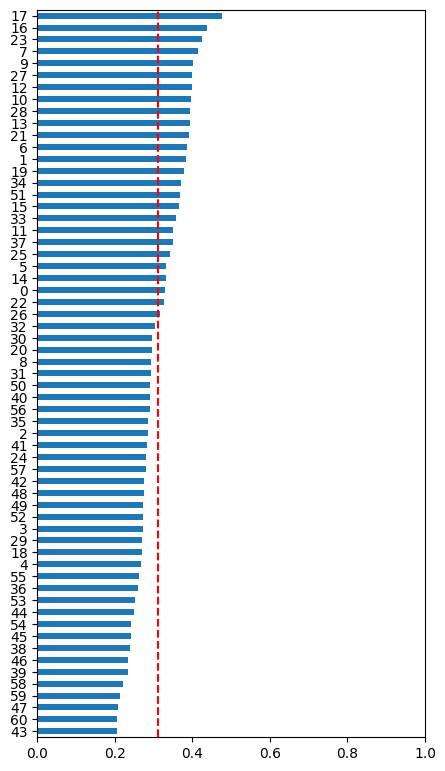

In [108]:
# viz
plot_topic_coherence_scores(coherence_scores, figsize=(5, n_topics*0.15))

## Silhouette scores

Silhouette scores are a measure of how well documents are assigned to their topics.
They are computed for each document and range from -1 to 1.
Specificallly, they are computed as follows:

- for each sample, compute
    - $a$, the mean distance between a sample and all other points in the same class, and 
    - $b$, the mean distance between a sample and all other points in the next nearest cluster.
    - the *silhouette coefficient* as $s = (b - a) / max(a, b)$ 
- compute the *silhouette score* for a clustering solution of a set of documents as the mean of the silhouette coefficients for all samples.

**Interpretation**

At the sample level:

- The higher the coeficient, the better the document is assigned to its topic.
- The lower the coeficient, the more likely it is that the document is not well assigned to its topic.

At the corpus level: the higher the scorem the better the clustering solution.

In [109]:
from sklearn.metrics import (
    silhouette_score, # <== compute overall, corpus-level score
    silhouette_samples # <== compute sample/document-level scores
)

In [110]:
# corpus level
overall_silhouette_score = silhouette_score(
    X=topic_model.umap_model.embedding_, 
    labels=topic_model.topics_, 
    sample_size=None, # <== None means do not subsample observations
    random_state=SEED # <== only used to make subsampling reproducible (if applied)
)
overall_silhouette_score

0.03126946836709976

In [111]:
silhouette_scores = silhouette_samples(X=topic_model.umap_model.embedding_, labels=topic_model.topics_)

In [112]:
# mean and standard deviation of silhouette scores by topic
silhouette_scores_by_topic = pd.DataFrame({
    'topic': topic_model.topics_, 
    'silhouette_score': silhouette_scores}
)
silhouette_scores_by_topic = silhouette_scores_by_topic.groupby('topic').agg(['mean', 'std'])
# remove stacked columns
silhouette_scores_by_topic.columns = silhouette_scores_by_topic.columns.droplevel(0)
silhouette_scores_by_topic.reset_index(inplace=True)
silhouette_scores_by_topic.sort_values(by='mean', ascending=False).reset_index(drop=True)

,topic,mean,std
0,25,0.929036,0.051967
1,60,0.868109,0.049034
2,38,0.834410,0.040490
3,50,0.823604,0.063423
4,52,0.812520,0.057049
...,...,...,...
58,0,0.329135,0.157983
59,20,0.308240,0.297438
60,22,0.280306,0.163075
61,2,0.127684,0.181505


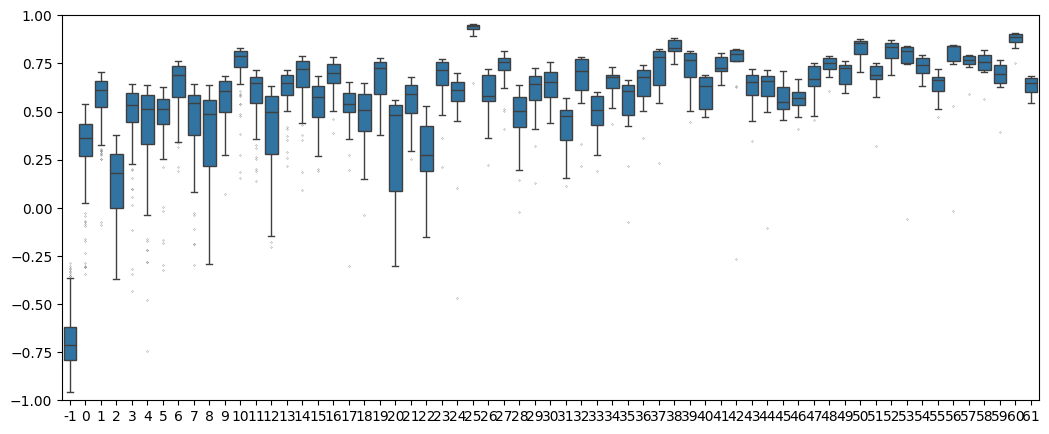

In [113]:
# plot a boxplot (along x-axis) by topic (y-axis)
plt.figure(figsize=(n_topics*0.2, 5))
sns.boxplot(x=topic_model.topics_, y=silhouette_scores, fliersize=.2)
plt.ylim(-1, 1)
plt.show()

There's always gonna be some heterogeneity in the quality *between* the topics identified by a topic model.
(If you ever fit a topic model where all topics have very high and concentrated silhouette scores, please send me an email with a screenshot.)

But the **aggregate information** is still useful to decide between different topic models fitted to the same data.


In [114]:
overall_silhouette_score, silhouette_scores_by_topic['mean'].mean(), silhouette_scores_by_topic['mean'].std()

(0.03126946836709976, 0.58413213, 0.22020127)

In [115]:
# without outliers
if has_outlier_topic:
    print(silhouette_scores_by_topic.iloc[1:,1].mean(), silhouette_scores_by_topic.iloc[1:,1].std())

0.60481495 0.14795808


In [116]:
silhouette_scores_by_topic.sort_values(by='mean', ascending=False).reset_index(drop=True)

,topic,mean,std
0,25,0.929036,0.051967
1,60,0.868109,0.049034
2,38,0.834410,0.040490
3,50,0.823604,0.063423
4,52,0.812520,0.057049
...,...,...,...
58,0,0.329135,0.157983
59,20,0.308240,0.297438
60,22,0.280306,0.163075
61,2,0.127684,0.181505


## Analysis at debate level

In [185]:
# create a dataframe with documents in the rows and their topic probabilities in the columns
tmp = pd.DataFrame(topic_model.probabilities_[:,int(has_outlier_topic):])

# add debate subject from metadata
tmp['debate_subject'] = df['debate_subject']

# average at level of debate
debate_topic_vectors = tmp.groupby('debate_subject').mean()

# sort by order of topic that is most salient
debate_topic_vectors['most_salient_'] = debate_topic_vectors.values.argmax(axis=1)
debate_topic_vectors.sort_values('most_salient_', inplace=True)
del debate_topic_vectors['most_salient_']

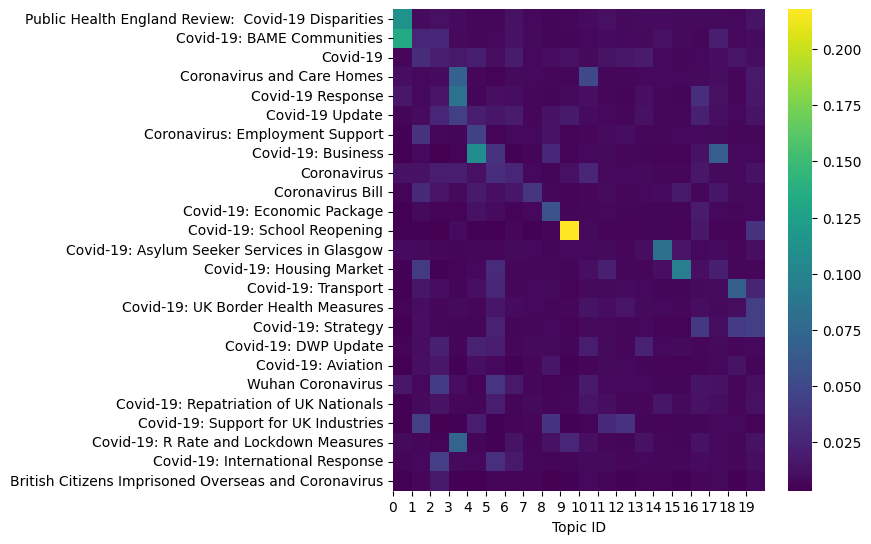

In [202]:
n_topics_ = len(set(topic_model.topics_))
if has_outlier_topic:
    n_topics_ -= 1
n_topics_ = 20 

# show all debate subjects
show_n_ = len(debate_topic_vectors)

# create a heatmap
plt.figure(figsize=(n_topics_*0.3, show_n_*0.25))
sns.heatmap(debate_topic_vectors.iloc[:show_n_, :n_topics_], cmap="viridis", annot=False, cbar=True, fmt="0.2f")
# plt.yticks(debate_topic_vectors.index[:show_n_].astype("category"))
plt.ylabel(None)
plt.xlabel('Topic ID')
plt.xticks(range(n_topics_), range(n_topics_), rotation=0)
# plt.title('Average Topic Probabilities by Debate subject')
plt.show()

Let's look at topic 9 that is super strongly expressed in debates about "Covid-19: School Reopening": 

In [203]:
topic_nr = 9
print("n:", topic_model.topic_sizes_[topic_nr])
topic_model.get_topic(topic_nr)[:10]

n: 70


[('uk government', 0.29991406),
 ('announcement', 0.28444618),
 ('provide', 0.27291685),
 ('supporting', 0.2646191),
 ('aware', 0.25333324),
 ('financial support', 0.24663454),
 ('chancellor', 0.23509681),
 ('ensuring', 0.22940674),
 ('letter', 0.22791119),
 ('assure', 0.22548842)]

In [204]:
# get exemplary documents for a given topic
topic_model.get_representative_docs(topic_nr)

['The Scottish Government have been clear that the stay-at-home advice has not changed, so will the Chancellor commit today to ensuring that the job retention scheme will remain in place in Scotland, Wales and Northern Ireland if our lockdowns continue longer than in England?',
 'However, before any reductions in furlough or rates of support start, we first need to fill the gaps for those left behind: those who had a contract or letter of employment by 29 March but whose employers have not logged into Her Majesty’s Revenue and Customs, those agency workers who are not included, staff whose pay is combined with commission, and the forgotten but vital summer seasonal workers.',
 'Does the Chancellor recognise that the continuation of the job retention scheme for as long as is necessary, together with welcome measures to help companies that are deeply in debt and battling with liquidity, will be crucial for the future, providing the necessary certainty upon which businesses, workers and t

# Appendix

## Hyper-parameter tuning

Hyper-parameter tuning refers to the process of finding "optimal" values for the so-called hyper-parameters of a machine learning model that affect how it fits to the data.
Optimal in this context always means optimal for a specific task and according to a (set of) pre-defined evaluation metric(s).
For example, in supervised learning (i.e., when there is labeled data available against which to compare predictons), we usually use metri s like the F1-score or accuracy to evaluate a model's performance.
But in the context of topic modeling, we usually don't have labeled data.
So we rely on the evaluation metrics we have discussed above.

In the context of BERTopic, the essential hyper-parameters are those that affect the dimensionality reduction and clustering components (see [here](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html)).
But you could also consider the choice of the embedding model a hyper-parameter.

#### Implementation

Although hyper-parameter tuning sounds advanced (see [here](see https://github.com/MaartenGr/BERTopic/issues/1642)), implementing it is relatively straightforward given what you've learned above.
We will just

1. define a list of hyper-parameter values to try
2. loop over these values and for each
    1. fit a model with these hyper-parameter values
    2. evaluate the model
3. select the model that performs best according to our evaluation metric(s)


In [121]:
from datetime import datetime
ts = lambda: datetime.now().strftime("%Y-%m-%d %H-%M-%S")
log = lambda msg: print(f'[{ts()}] {msg}')

In [122]:
from sklearn.cluster import KMeans

n_topics = list(range(5, 50, 5)) # note: range excludes 50 (so this will run for 5, 10, 15, ..., 45)
# add some very high values for comparison
n_topics.append(70)

metrics = {}

for k in n_topics:
    
    metrics[k] = {}
    
    # build
    tm = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=KMeans(n_clusters=k, random_state=SEED), # <== vary number of clusters/topics
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=KeyBERTInspired(top_n_words=30),
        top_n_words=30,
        nr_topics=None,
        verbose=False
    )
    
    # train
    log(f'fitting model with {k} topics')
    topics, _ = tm.fit_transform(
        df.text,
        embeddings=embeddings # <== here we take the pre-computed embeddings for efficiency
    )
    
    # evaluate
    log(f'computing evaluation metrics for model with {k} topics')
    metrics[k]['coherence'], _ = compute_coherece(tm, df.text)
    metrics[k]['silhouette'] = compute_silhouette_scores(tm)
    log(f'done evaluating model with {k} topics')
    
    print()


[2025-09-23 16-09-55] fitting model with 5 topics
[2025-09-23 16-10-14] computing evaluation metrics for model with 5 topics


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2025/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2025/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2025/lib/python3.11/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2025/lib/python3.11/site-packages/gensim/corpora/__init__.py", line 6, in 

KeyboardInterrupt: 

**_Note:_** 
We only explore the number of cluster parameter which will determine the number of topics.
If we were using HDBSCAN for clustering, this would be equivalent to altering `min_cluster_size`.

We could also explore other hyper-parameters,  such as `n_components` of the dimensionality reduction component.
This would be computationally expensive, because for each `n_components` value, we'd need to fit and evaluate one topic model per `n_topics` value (so-called grid search).

But the code would just require a second (inner) loop:

```python
n_topics = [5, 10, 15, 20]
n_components = [5, 10, 15, 20]

for k in n_topics:
    for d in n_components:
        # fit model
        ...
        # evaluate model
        ...
```


In [ ]:
# Plot coherence as a function of k
tmp = pd.DataFrame([(k, d['coherence']['overall']) for k, d in metrics.items()])
#plt.figure(figsize=(10, 6))
plt.plot(tmp[0], tmp[1], marker='o')
plt.title('Coherence Score as a Function of Number of Topics (k)')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')
plt.xticks(tmp[0])  # Set x-axis ticks to the actual values of k
plt.grid(True)
plt.show()

In [ ]:
# Plot coherence as a function of k
tmp = pd.DataFrame([(k, d['silhouette']['overall']) for k, d in metrics.items()])
#plt.figure(figsize=(10, 6))
plt.plot(tmp[0], tmp[1], marker='o')
plt.title('Silhouette Score as a Function of Number of Topics (k)')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Silhouette Score')
plt.xticks(tmp[0])  # Set x-axis ticks to the actual values of k
plt.grid(True)
plt.show()